# [2023-10-31] Circadian factor stability

In this notebook, we begin to examine the stability of fitted factors.

Specifically, we compare the factors fitted to models $(50, \{4,8\}, 30)$.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import wandb

import pandas as pd 
import numpy as np
onp = np
import itertools
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_style("darkgrid")

In [22]:
## WandB helper functions, to be refactored
def get_results_df(entity, project, config_keys, summary_keys):
    """Project is specified by <entity/project-name>"""
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(f"{entity}/{project}")

    run_results = {key: [] for key in itertools.chain(['id', 'name'], config_keys, summary_keys)}

    for run in runs: 

        # .summary contains the output keys/values for metrics like accuracy.
        # use .get to catch NaN runs (e.g. due to OOM)
        for key in summary_keys:
            run_results[key].append(run.summary.get(key,))

        # .config contains the hyperparameters.
        for key in config_keys:
            run_results[key].append(run.config[key])

        # .name is the human-readable name
        run_results['name'].append(run.name)
        run_results['id'].append(run._attrs['name'])

    return pd.DataFrame(run_results)

def download_params(entity: str, project: str, run_id: str):
    """Return tuple of params for the given run."""

    api = wandb.Api()

    run = api.run(f"{entity}/{project}/{run_id}")

    # run.file(...).download(...) only seems to recognize paths relative to cwd
    rel_path = f'../temp/{run_id}'

    # If file already exists, do not re-download
    run.file("params.npz").download(root=rel_path, exist_ok=True)

    params = np.load(Path(rel_path)/'params.npz')

    return params['G'], params['F1'], params['F2'], params['F3']


In [19]:
## Syllable viz and TOD viz functions, to be refactored
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from scipy.cluster.hierarchy import linkage, leaves_list    # For hierarchically clustering topics

# Syllable permutations, based on KL-divergence of syllable parameters
# - SYLLABLE_PERM_DICT: Consists of (cluster_name: indices) items and is used
#                       for annotating figures (see `set_syllable_cluster_ticks`)
# - SYLLABLE_PERM: Used for permutating syllable parameters
SYLLABLE_PERM_DICT = OrderedDict([
    ('inactive', [91, 97, 30, 10, 1, 43, 69] + [33,] + [99,]),                   # 99: Belly
    ('pause and drift', [32, 51, 82, 0, 56, 14, 19, 84, 92, 7, 66, 3, 17, 57, 85, 46, 27, 65]),
    ('straight swim', [9, 31, 28, 80, 68, 73, 6, 54, 58, 70, 39, 40, 25, 42, 89, 45, 77, 24, 60, 74, 94]),
    ('edge+sidebody', [63, 72, 15, 98, 23, 96, 36, 83, 55, 90, 76, 61, 88] + [50,]),
    ('j-turn+reverse', [44, 75, 59, 95, 48, 78, 18, 16, 35, 47],),
    ('aggression+glass surf', [71, 11, 64, 81, 87, 20, 21, 37, 8, 41, 52, 26, 93, 38, 12, 22, 5]),
    ('nose down', [86, 49, 67, 79, 2, 13, 62, 29, 34, 4, 53]),
])
SYLLABLE_PERM = list(itertools.chain.from_iterable(SYLLABLE_PERM_DICT.values()))

def set_syllable_cluster_ticks(ax=None, axis='x', font_kws={'fontsize': 'small'}):
    """Label specified axis with syllable _cluster_ names."""

    if ax is None:
        ax = plt.gca()

    cluster_names = list(SYLLABLE_PERM_DICT.keys())
    cluster_sizes = [len(v) for v in SYLLABLE_PERM_DICT.values()]
    
    maj_ticks = onp.cumsum([0,] + cluster_sizes) - 0.5
    min_ticks = onp.diff(maj_ticks) / 2 + maj_ticks[:-1]

    if axis == 'x':
        # Draw major ticks
        ax.set_xticks(maj_ticks)
        ax.tick_params(axis='x', which='major', length=5, labelbottom=False,)
        ax.grid(visible=True, which='major', axis='x', alpha=0.2, lw=0.5)

        # Annotate between the ticks
        ax.set_xticks(min_ticks, cluster_names, minor=True, **font_kws)
        ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=True)
    else:
        # Draw major ticks
        ax.set_yticks(maj_ticks)
        ax.tick_params(axis='y', which='major', length=5, labelleft=False,)
        ax.grid(visible=True, axis='y', which='major', alpha=0.2, lw=0.5)

        # Annotate between the ticks
        ax.set_yticks(min_ticks, cluster_names, minor=True, **font_kws)
        ax.tick_params(axis='y', which='minor', left=False, labelleft=True)
    
    return ax


def draw_syllable_factors(params, ax=None):
    # Permute syllables to match our KL-clustering for better interpretability
    syllable_factors = params[3][:,SYLLABLE_PERM]
    K, D = syllable_factors.shape

    # Use hiearchical clustering on syllable factor ("behavioral topic") axis
    method = 'centroid'
    metric = 'euclidean'
    topic_perm = leaves_list(linkage(syllable_factors, method, metric)).astype(int)

    syllable_factors = syllable_factors[topic_perm,:]

    # ------------------------------------------------------------------------
    fig = plt.figure(figsize=(16, 4.5), dpi=96) if ax is None else ax.figure
    ax = plt.gca() if ax is None else ax
    im = ax.imshow(syllable_factors, interpolation='none', aspect='auto',
                   cmap='magma', norm=mplc.LogNorm(0.5/D, 1.0))
    set_syllable_cluster_ticks(ax)
    plt.colorbar(im, ax=ax, extend='min')

    # Visually demarcate each behavioral topic
    ax.set_yticks(onp.arange(K)-0.5, [])
    ax.grid(visible=True, which='major', axis='y', alpha=0.8, lw=0.5)
    ax.set_ylabel('syllable factors / "behavioral topics"')

    return plt.gcf()

# ==============================================================================
def make_tod_series(freq):
    """Make time-of-day datetime.time points spaced at the given frequency.

    If `resample_rule='30min'`, then constructs returns array consisting of
        [(00:00:00), (00:30:00), ..., (23:00:00), (23:30:00)]

    Parameters
        freq: Pandas timedelta offset or offset string alias. See:
            https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    """

    last_label = (
        (pd.to_datetime("00:00:00") - pd.Timedelta(freq)).to_pydatetime()
                                                         .time()
                                                         .strftime(format='%H:%M:%S')
    )

    return pd.date_range('00:00:00', last_label, freq=freq).time

def draw_circadian_bases(params, axs=None):
    circadian_bases = params[2]
    D, K = circadian_bases.shape

    # Permute the circadian bases so that they are sorted by earliest peak
    t_peak = onp.argmax(circadian_bases, axis=0)
    basis_perm = onp.argsort(t_peak, kind='stable')
    circadian_bases = circadian_bases[:, basis_perm]

    # Share a common a y-axis
    ymax = circadian_bases.max()

    # ------------------------------------------------------------------------
    if axs is None:
        _, axs = plt.subplots(nrows=K, ncols=1, squeeze=True,
                              gridspec_kw={'hspace':0.1}, figsize=(8,9), dpi=96)
    assert len(axs) == K, f'Expected {len(axs)} axes, expected {K}, i.e. one per basis'
        
    for k, ax in enumerate(axs):
        # Plot basis, and adjust x-axis days with human-interpretable times
        ax.plot(circadian_bases[:,k])
    
        # Grey out background if factor L2 norm is below a threshold
        mag = onp.linalg.norm(circadian_bases[:,k])
        if mag <= 0.3:
            ax.set_facecolor('0.8')
            ax.annotate(f'|factor|={mag:.2f}', (0.01,0.9), xycoords='axes fraction',
                        va='top', fontsize='small')
        
        # Label x-axis with time-of-day from 0H - 24H, every 2H
        t_dts = make_tod_series('2H')        
        t_locs = onp.concatenate([onp.linspace(0, D, num=len(t_dts), endpoint=False), [D]])
        t_labels = list(map(lambda dt: dt.strftime('%H'), t_dts)) + ['24']
        
        ax.set_xticks(t_locs)
        ax.set_xticklabels(t_labels)

        # Label y-axis with "circadian bases"
        if k == K // 2:
            ax.set_ylabel('time-of-day factors / "circadian bases"')

        # Set axis limits; reduce blank space margins
        ax.set_ylim(bottom=-0.1, top=1.1*ymax)
        ax.margins(x=0.01, y=0.5)

        # Draw time-of-day ticks; only annotate bottom-most subplot
        ax.tick_params(labelleft=False, labelbottom=False)
        if k == K-1:
            ax.tick_params(labelbottom=True)
            ax.set_xlabel('time of day [24hr]')
        
        # Despine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return plt.gcf()

In [12]:
type(ax.figure)

matplotlib.figure.Figure

## Load all runs associated with (K1=50, K2={4,8}, K3=30)

Pull data from WandB server into a Pandas dataframe.

In [5]:
# Project is specified by <entity/project-name>
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

config_keys = ['seed', 'k1', 'k2', 'k3']
summary_keys = ['pct_dev']

df = get_results_df(wnb_entity, wnb_project, config_keys, summary_keys)

In [6]:
# Choose runs for which (K1=50, K2=4)
df = df[(df['k1'] == 50) \
        & ((df['k2'] == 4) | (df['k2'] == 8)) \
        & (df['k3'] == 30)]

# Drop rows that have NaN pct_dev
df = df.dropna(axis=0)

print(f"{len(df)} total runs, {df['k2'].nunique()} unique K_2 ranks: {sorted(df['k2'].unique())}")

9 total runs, 2 unique K_2 ranks: [4, 8]


## Evaluate K2=4 factors

I expected the model with $K_3=100$ to be overfit to the data, and hence for the held-out log likelihood to be lower
than simpler models that do not overfit to the data. However, this may be too naive of an assumption.

# Fitted behavioral topics

Text(0.5, 0.98, 'k2 = 4')

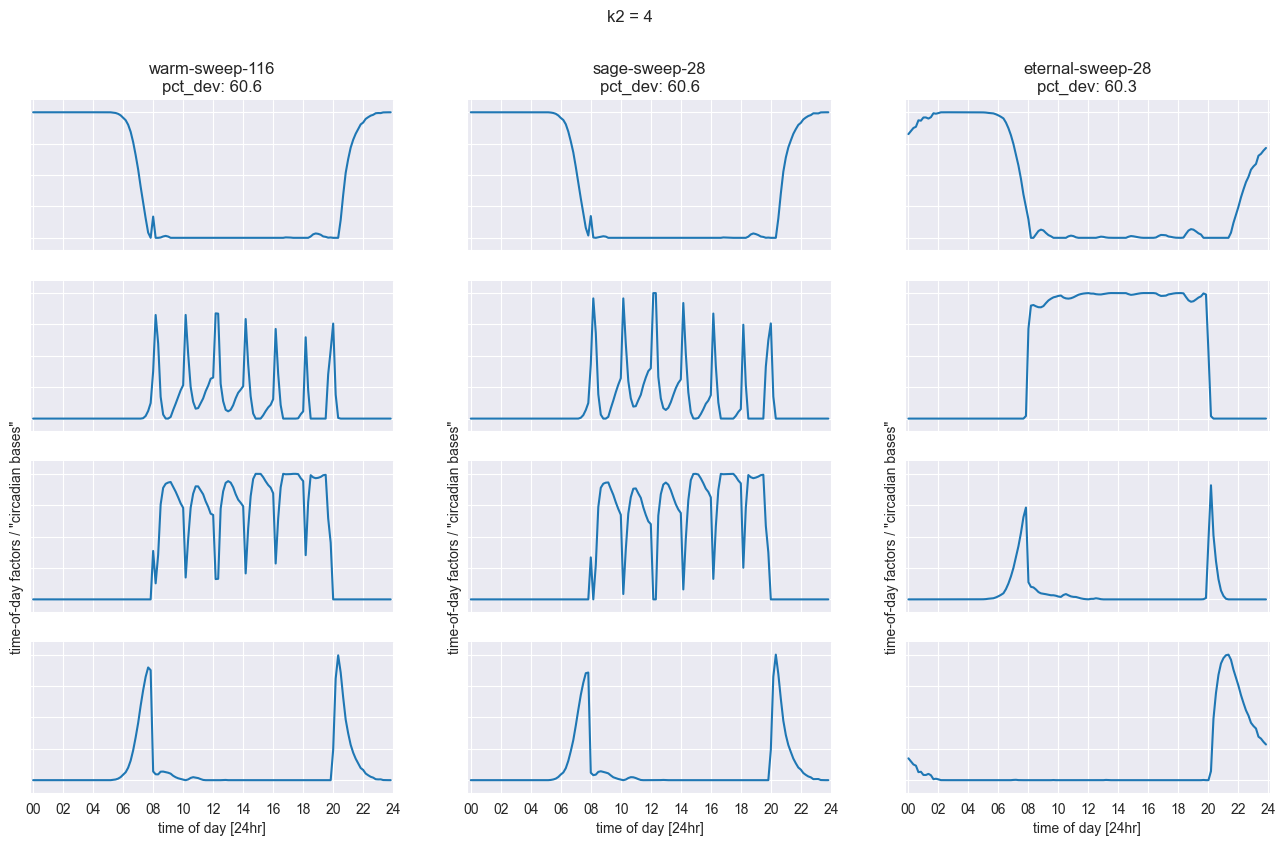

In [30]:
import matplotlib.gridspec as gridspec

k2 = 4

# -------------------------------------------
subdf = df[df['k2'] == k2]
params = [download_params(wnb_entity, wnb_project, _id) for _id in subdf['id']]

# -------------------------------------------
fig = plt.figure(figsize=(16,9))

n_runs = len(subdf)
gs_outer = gridspec.GridSpec(nrows=1, ncols=n_runs, figure=fig)

for i_run, _params in enumerate(params):
    gs_inner = gs_outer[i_run].subgridspec(k2, 1)
    
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(k2)]
    draw_circadian_bases(_params, axs)

    axs[0].set_title(f"{subdf.iloc[i_run]['name']}\npct_dev: {subdf.iloc[i_run]['pct_dev']:.1f}")

fig.suptitle(f'k2 = {k2}')

## Evaluate on K2=8

Text(0.5, 0.98, 'k2 = 8')

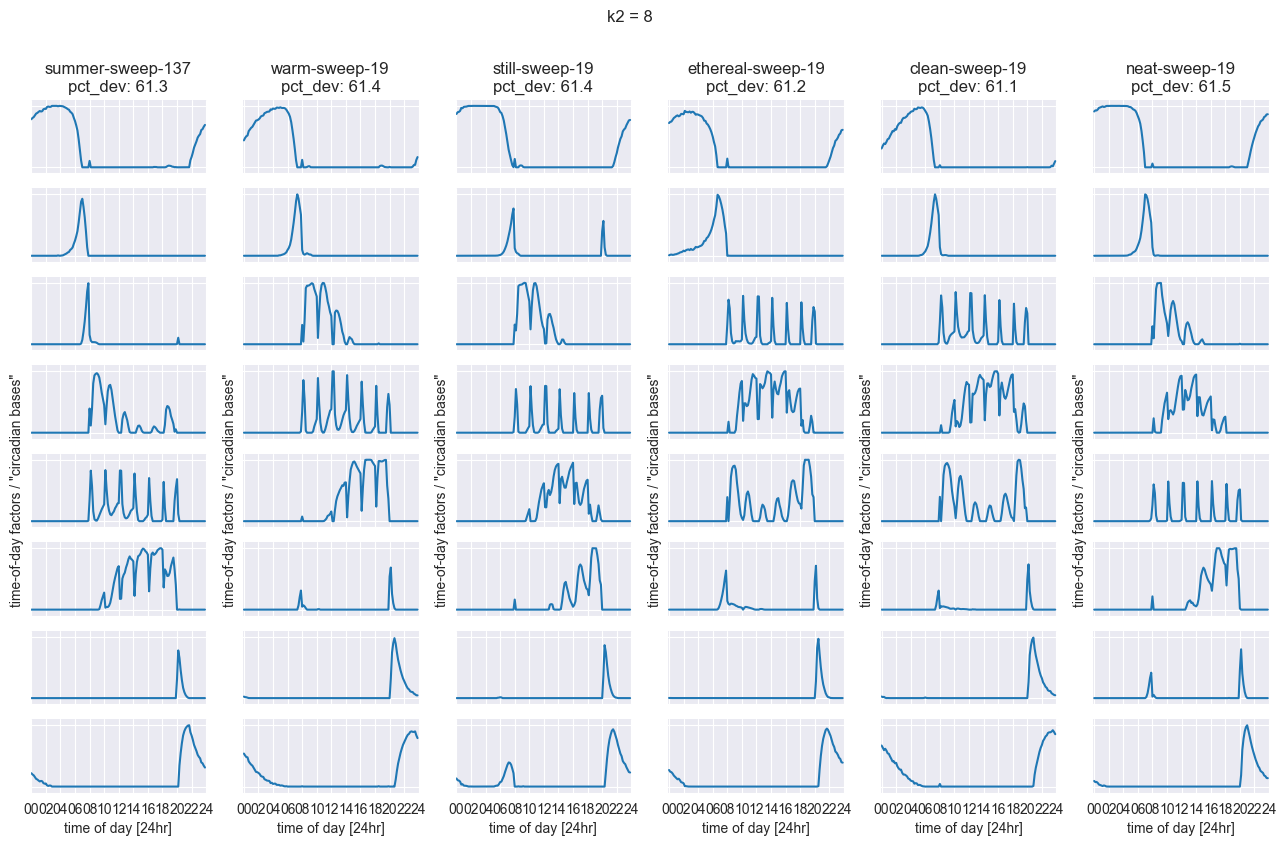

In [29]:
import matplotlib.gridspec as gridspec

k2 = 8

# -------------------------------------------
subdf = df[df['k2'] == k2]
params = [download_params(wnb_entity, wnb_project, _id) for _id in subdf['id']]

# -------------------------------------------
fig = plt.figure(figsize=(16,9))

n_runs = len(subdf)
gs_outer = gridspec.GridSpec(nrows=1, ncols=n_runs, figure=fig)

for i_run, _params in enumerate(params):
    gs_inner = gs_outer[i_run].subgridspec(k2, 1)
    
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(k2)]
    draw_circadian_bases(_params, axs)

    axs[0].set_title(f"{subdf.iloc[i_run]['name']}\npct_dev: {subdf.iloc[i_run]['pct_dev']:.1f}")

fig.suptitle(f'k2 = {k2}')

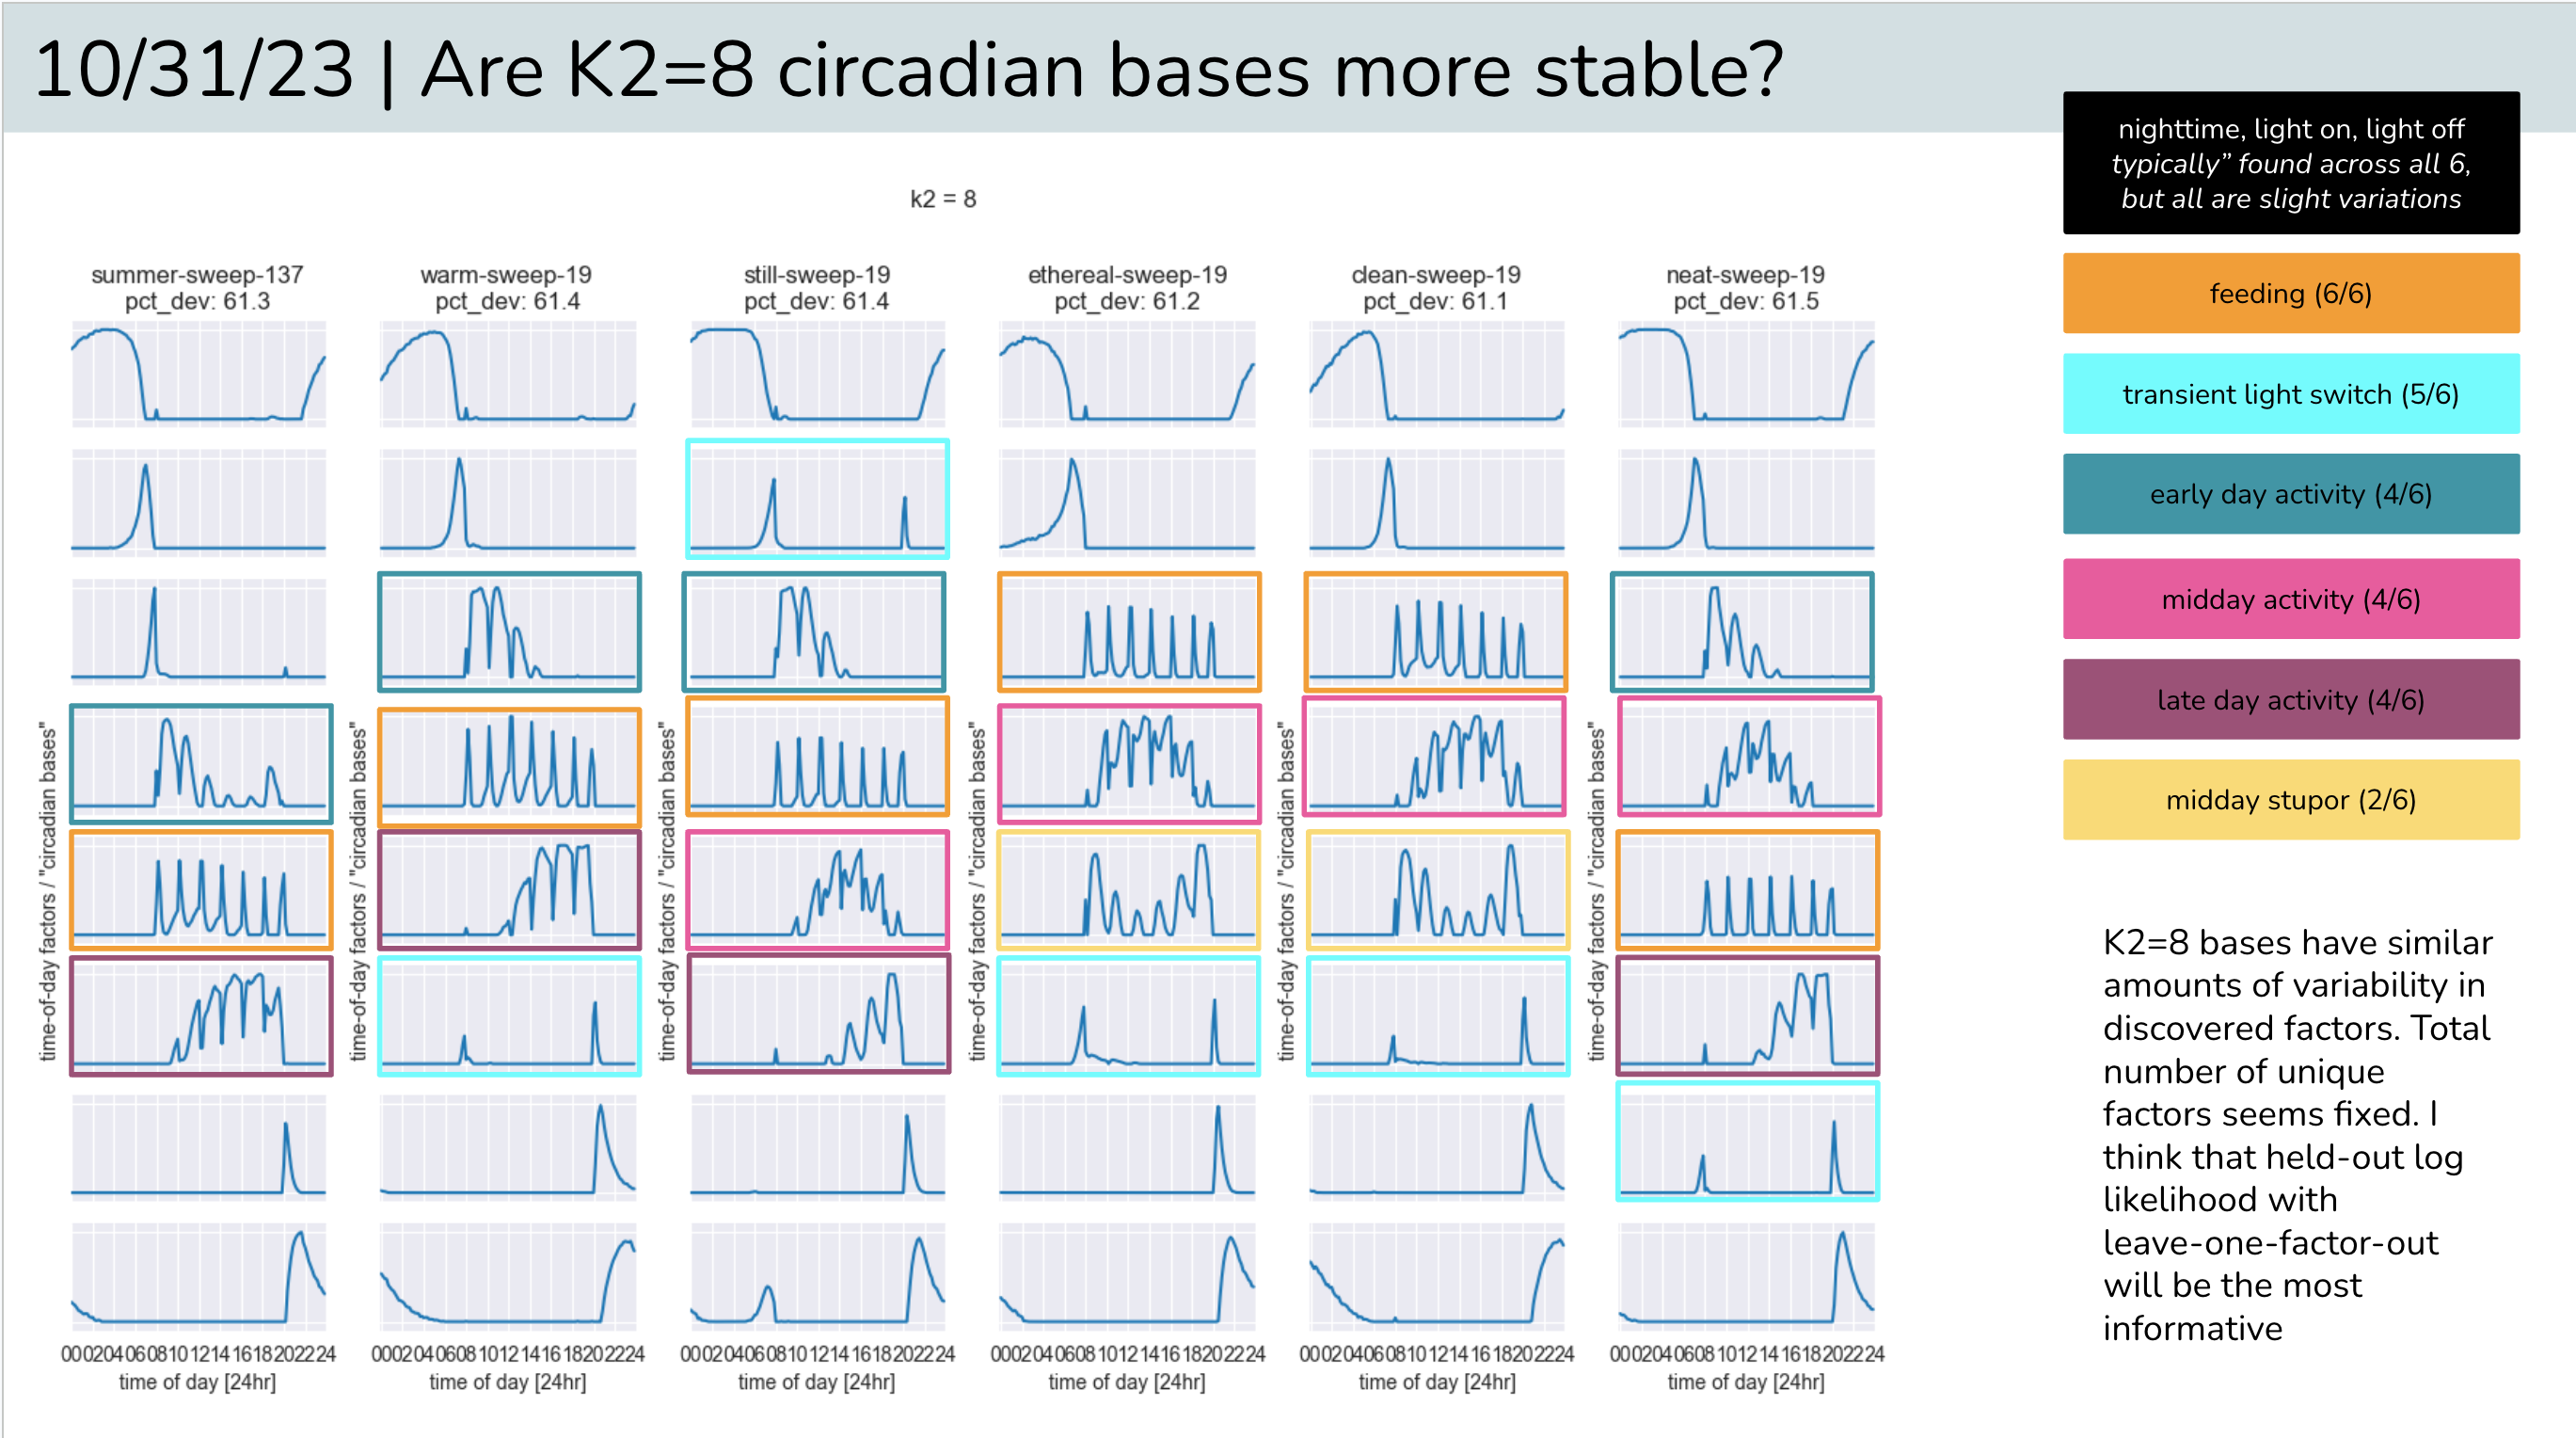